## Modules

In [240]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from dirty_cat import SimilarityEncoder

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

import pickle
# Data visualization
import cufflinks as cf

import warnings
cf.go_offline()
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

## Relevant functions

In [50]:
def splitSentimentScore(json):
    return [x.split(":")[1] for x in json.split(",")]

In [110]:
def dropTwitterTags(tweet):
    clean_tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)
    clean_tweet = re.sub(r'http\S+', "",clean_tweet)
    return clean_tweet.strip()

In [159]:
def textPrepo(df):
    df_text=df.copy()
    #### Drop punctation and tags
    df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: dropTwitterTags(x))
    punctuation_chars = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~|'
    mapping_table = str.maketrans("","",punctuation_chars)
    df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: x.translate(mapping_table))
    del punctuation_chars,mapping_table
    #### Remove excedent spaces and capitals
    df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: x.lower())
    df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: re.sub(' +', ' ', x))
    #### Stopwords and stemer
    nltk.download('stopwords')
    stopword_list  = stopwords.words('spanish')
    df_text["tweet_text"]= df_text["tweet_text"].str.split()
    df_text["tweet_text"]= df_text["tweet_text"].apply(lambda x: [i for i in x if i not in stopword_list])
    stemmer = SnowballStemmer('spanish')
    df_text["tweet_text"]= df_text["tweet_text"].apply(lambda x: [stemmer.stem(i) for i in x])
    df_text["tweet_text"]= df_text["tweet_text"].apply(lambda x: ' '.join(x))
    df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: re.sub(' +', ' ', x))
    del stopword_list,stemmer
    return df_text

## Load data

In [2]:
data= pd.read_csv("Data/betsentiment-ES-tweets-sentiment-teams.csv",encoding='latin-1')

In [3]:
data.head()

,tweet_date_created,tweet_id,tweet_text,language,sentiment,sentiment_score
0,2018-08-08T13:09:15.489000,1027179935184703489,"Alisson puede estar más tranquilo, no cargará ...",es,POSITIVE,"{""Neutral"":0.082259356975555419921875,""Negativ..."
1,2018-08-08T18:27:37.320000,1027260056092344320,@iPincheViky @ChelseaFC Es que el director eje...,es,NEUTRAL,"{""Neutral"":0.827011644840240478515625,""Negativ..."
2,2018-08-12T14:59:31.520000,1028657238116843520,Upto £100 #freebets &gt; https://t.co/cbjeMXI9...,es,NEUTRAL,"{""Neutral"":0.930982112884521484375,""Negative"":..."
3,2018-08-04T13:23:30.257000,1025733971320160257,"Bobby Duncan, primo de Steven Gerrard, deja la...",es,NEUTRAL,"{""Neutral"":0.906872212886810302734375,""Negativ..."
4,2018-07-28T11:21:06.480000,1023166450981396480,@TorreiraForeva @lepvtron @Arsenal @IntChampio...,es,NEUTRAL,"{""Neutral"":0.942405760288238525390625,""Negativ..."


## Preprocessing

In [111]:
df= data.copy()

### Split sentiment_score

In [112]:
ls_neutral=[]
ls_negative=[]
ls_positive=[]
ls_mixed=[]
for _,row in df.iterrows():
    json=row["sentiment_score"][1:-1]
    neutral,negative,positive,mixed= splitSentimentScore(json)
    ls_neutral.append(float(neutral))
    ls_negative.append(float(negative))
    ls_positive.append(float(positive))
    ls_mixed.append(float(mixed))
    
df["neutral"]= ls_neutral
df["negative"]= ls_negative
df["positive"]= ls_positive
df["mixed"]= ls_mixed

In [113]:
df.drop(columns=['tweet_date_created', 'language', 'sentiment','sentiment_score',], inplace=True)

In [114]:
df.head()

,tweet_id,tweet_text,neutral,negative,positive,mixed
0,1027179935184703489,"Alisson puede estar más tranquilo, no cargará ...",0.08,0.04,0.75,0.14
1,1027260056092344320,@iPincheViky @ChelseaFC Es que el director eje...,0.83,0.08,0.07,0.02
2,1028657238116843520,Upto £100 #freebets &gt; https://t.co/cbjeMXI9...,0.93,0.03,0.03,0.01
3,1025733971320160257,"Bobby Duncan, primo de Steven Gerrard, deja la...",0.91,0.06,0.02,0.01
4,1023166450981396480,@TorreiraForeva @lepvtron @Arsenal @IntChampio...,0.94,0.03,0.02,0.01


### Text

In [160]:
df_text=df.copy()

In [133]:
df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: dropTwitterTags(x))

#### Punctation characters

In [134]:
punctuation_chars = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~|'

In [135]:
mapping_table = str.maketrans("","",punctuation_chars)

In [136]:
df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: x.translate(mapping_table))

In [137]:
df.tweet_text[132705]

'Amistoso, champions o Liga; el city es la perra del Liverpool #YNWA'

In [131]:
df_text.tweet_text[132705]

'Amistoso champions o Liga el city es la perra del Liverpool'

#### Remove excedent spaces and capitals

In [138]:
df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: x.lower())
df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: re.sub(' +', ' ', x))

In [139]:
df.head()

,tweet_id,tweet_text,neutral,negative,positive,mixed
0,1027179935184703489,"Alisson puede estar más tranquilo, no cargará ...",0.08,0.04,0.75,0.14
1,1027260056092344320,@iPincheViky @ChelseaFC Es que el director eje...,0.83,0.08,0.07,0.02
2,1028657238116843520,Upto £100 #freebets &gt; https://t.co/cbjeMXI9...,0.93,0.03,0.03,0.01
3,1025733971320160257,"Bobby Duncan, primo de Steven Gerrard, deja la...",0.91,0.06,0.02,0.01
4,1023166450981396480,@TorreiraForeva @lepvtron @Arsenal @IntChampio...,0.94,0.03,0.02,0.01


#### Stopwords

In [140]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bluterplay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [144]:
stopword_list  = stopwords.words('spanish')

In [147]:
df_text["tweet_text"]= df_text["tweet_text"].str.split()

In [149]:
df_text["tweet_text"]= df_text["tweet_text"].apply(lambda x: [i for i in x if i not in stopword_list])

In [150]:
df_text

,tweet_id,tweet_text,neutral,negative,positive,mixed
0,1027179935184703489,"[alisson, puede, tranquilo, cargará, peso, ser...",0.08,0.04,0.75,0.14
1,1027260056092344320,"[director, ejecutivo, mujer, so, jajajajjaa]",0.83,0.08,0.07,0.02
2,1028657238116843520,"[upto, £100, gt]",0.93,0.03,0.03,0.01
3,1025733971320160257,"[bobby, duncan, primo, steven, gerrard, deja, ...",0.91,0.06,0.02,0.01
4,1023166450981396480,"[leon, bailey, or, federico, cheisa]",0.94,0.03,0.02,0.01
...,...,...,...,...,...,...
132702,1028037572671545345,"[apunta, diario, mirror, pensando, reuperar, z...",0.90,0.07,0.01,0.01
132703,1030680133189992448,"[mejor, puede, pasar, ospina, pongan, competen...",0.73,0.01,0.21,0.04
132704,1041369661399547904,"[final, partido, 1, vs, 3, jornada, 5]",0.96,0.01,0.03,0.00
132705,1022299986762129409,"[amistoso, champions, liga, city, perra, liver...",0.94,0.03,0.02,0.01


### Stemeer

In [151]:
stemmer = SnowballStemmer('spanish')

In [152]:
df_text["tweet_text"]= df_text["tweet_text"].apply(lambda x: [stemmer.stem(i) for i in x])

In [153]:
df_text["tweet_text"]= df_text["tweet_text"].apply(lambda x: ' '.join(x))

In [154]:
df_text["tweet_text"]= df_text["tweet_text"].map(lambda x: re.sub(' +', ' ', x))

### Encoder

In [158]:
similarity_encoder = SimilarityEncoder(ngram_range=(2, 5), categories='most_frequent', n_prototypes= 100)
transformed_values = similarity_encoder.fit_transform(df_text[["tweet_text"]])

In [176]:
df_final=df_text.iloc[:,-4:].copy()

In [178]:
ls_emb= ["Emb_"+str(x+1) for x in  range(100)]
df_final[ls_emb]= transformed_values

/tmp/ipykernel_4718/3327082482.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[ls_emb]= transformed_values


In [241]:
with open('models/tweets/similarity_encoder.pickle', 'wb') as f:
    pickle.dump(similarity_encoder, f)

### Train test 

In [191]:
X= df_final[ls_emb].values
y= df_final.iloc[:,:4].values

In [197]:
x_train,x_test,y_train,y_test= train_test_split(X,y, random_state=0,test_size=.2 )

## Model

### Define architeture

In [203]:
# Create a sequential model
model = Sequential()

# Add a dense layer with 50 neurons and ReLU activation function
model.add(Dense(50, input_dim=100, activation='relu'))

# Add a dense output layer with 4 neurons and linear activation function
model.add(Dense(4, activation='linear'))

In [204]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 4)                 204       
                                                                 
Total params: 5,254
Trainable params: 5,254
Non-trainable params: 0
_________________________________________________________________


### Call backs

In [207]:
kmetrics = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae'),
    metrics.MeanAbsolutePercentageError(name="pema")
]   

In [209]:
early_stopping = EarlyStopping(monitor='val_mae', patience=20)
checkpoint = ModelCheckpoint('models/tweets/model_{val_mae:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_mae')

In [215]:
model.compile(loss='mse', optimizer='adam', metrics=kmetrics)

### Train

In [216]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/100
3318/3318 [==============================] - 8s 2ms/step - loss: 0.0278 - rms: 0.1667 - mae: 0.1081 - pema: 3387.0037 - val_loss: 0.0269 - val_rms: 0.1639 - val_mae: 0.1053 - val_pema: 1484.7267
Epoch 2/100
3318/3318 [==============================] - 7s 2ms/step - loss: 0.0275 - rms: 0.1657 - mae: 0.1073 - pema: 3425.5474 - val_loss: 0.0267 - val_rms: 0.1633 - val_mae: 0.1031 - val_pema: 1300.0111
Epoch 3/100
3318/3318 [==============================] - 7s 2ms/step - loss: 0.0272 - rms: 0.1650 - mae: 0.1067 - pema: 3276.6086 - val_loss: 0.0265 - val_rms: 0.1628 - val_mae: 0.1066 - val_pema: 1546.1395
Epoch 4/100
3318/3318 [==============================] - 7s 2ms/step - loss: 0.0270 - rms: 0.1644 - mae: 0.1062 - pema: 3434.0205 - val_loss: 0.0267 - val_rms: 0.1634 - val_mae: 0.1096 - val_pema: 1497.0197
Epoch 5/100
3318/3318 [==============================] - 8s 2ms/step - loss: 0.0269 - rms: 0.1639 - mae: 0.1058 - pema: 3380.3958 - val_loss: 0.0265 - val_rms: 0.1628 - val

### Results

In [217]:
results = pd.DataFrame(history.history)

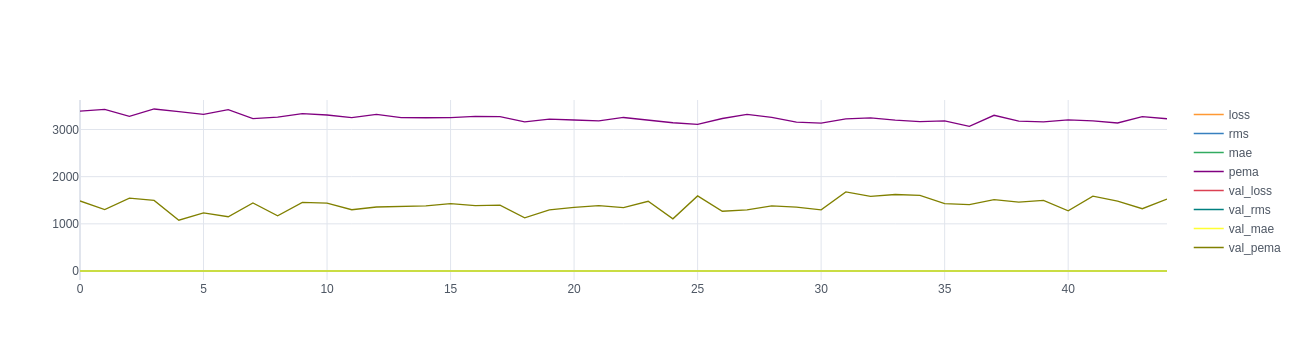

In [219]:
results.iplot()

In [168]:
s={"tweet_text": "#PremierLeague | El @ManCity sufre su primer empate ante el Wolverhamton, quien pego primero con gol de Boly, pero Laporte puso tablas en el Molineux Stadium. Los sky bluesbajaron a la segunda posicion de la tabla. https://t.co/3EbR2DP6vM"}

In [169]:
test= pd.DataFrame(s, index=range(1))

In [226]:
test_trans= textPrepo(test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bluterplay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [227]:
test_trans

,tweet_text
0,sufr prim empat wolverhamton peg primer gol bo...


In [228]:
test_enc=similarity_encoder.transform(test_trans[["tweet_text"]])

In [230]:
test_enc

array([[0.01275046, 0.01449275, 0.00598802, 0.01906412, 0.00203666,
        0.01002004, 0.        , 0.03262411, 0.01275046, 0.02919708,
        0.02803738, 0.04078762, 0.03397341, 0.06666667, 0.04280156,
        0.00205339, 0.04928458, 0.0674974 , 0.03085299, 0.0573913 ,
        0.02712477, 0.03505843, 0.01510574, 0.01353965, 0.01792115,
        0.03588144, 0.0368    , 0.03050847, 0.02405498, 0.00888099,
        0.03904924, 0.02793296, 0.02199662, 0.00210526, 0.03067485,
        0.01132075, 0.03559871, 0.00429185, 0.00986193, 0.02359347,
        0.06756757, 0.008     , 0.03333333, 0.01333333, 0.00628931,
        0.0174216 , 0.0041841 , 0.0212766 , 0.01123596, 0.0214168 ,
        0.02054795, 0.04823151, 0.03092784, 0.04012841, 0.01333333,
        0.04458599, 0.02018349, 0.05730129, 0.02389078, 0.03925234,
        0.03247863, 0.03401361, 0.01960784, 0.03937008, 0.01538462,
        0.02018349, 0.05621806, 0.01872659, 0.02276708, 0.01010101,
        0.02821317, 0.01974865, 0.02962963, 0.04

In [231]:
test_enc.shape

(1, 100)

In [237]:
predictions=model.predict(test_enc)[0]

1/1 [==============================] - 0s 30ms/step


In [239]:
predictions[0]

0.68492705